In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
fs = 48000
N = 2048

In [3]:
#bark scale
def bark(f):
    return 13*np.arctan(.76*f/1000)+3.5*np.arctan((f/7500)**2)

def get_subband_index(f):
    return int(bark(f))

def bin_to_subband_index(k, fs=48000, N=2048):
    return 1 + int(bark(k * fs / N))

In [4]:
print(bin_to_subband_index(0, 8000, N))
print(bin_to_subband_index(2048, 8000, N))
print(bin_to_subband_index(1023, 48000, N))

1
22
25


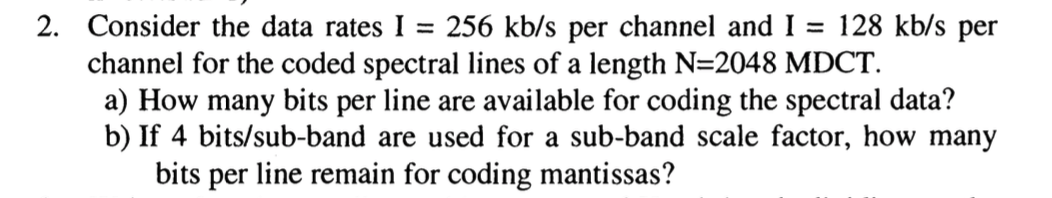

In [5]:
def R_k(data_rate, fs):
    return data_rate / fs

def block_bits_per_channel(R_k, N) :
    return R_k * N / 2

In [6]:
print(R_k(256000, fs))
print(R_k(128000, fs))

5.333333333333333
2.6666666666666665


In [7]:
print(int(block_bits_per_channel(R_k(256000, fs), N) - 100))
print(int(block_bits_per_channel(R_k(128000, fs), N) - 100))

5361
2630


In [8]:
# bits per line
print(int(block_bits_per_channel(R_k(256000, fs), N) - 100) / 1024)
print(int(block_bits_per_channel(R_k(128000, fs), N) - 100) / 1024)

5.2353515625
2.568359375


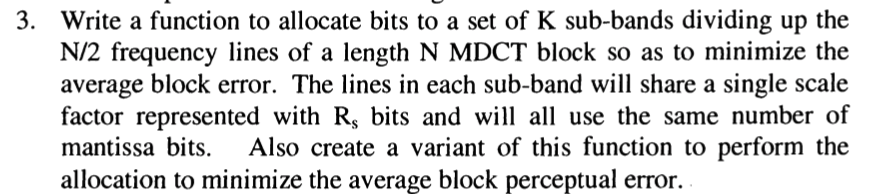

In [9]:
int(N/2)

1024

In [10]:
K = 25
k_map = {k:0 for k in range(1, K+1)}

for bin in range(N//2): 
    k = bin_to_subband_index(bin, fs, N)
    k_map[k] = k_map[k] + 1
k_map

{1: 5,
 2: 4,
 3: 5,
 4: 4,
 5: 5,
 6: 5,
 7: 6,
 8: 6,
 9: 7,
 10: 7,
 11: 9,
 12: 10,
 13: 11,
 14: 15,
 15: 17,
 16: 22,
 17: 26,
 18: 31,
 19: 36,
 20: 43,
 21: 52,
 22: 66,
 23: 96,
 24: 171,
 25: 365}

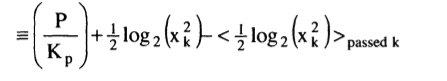

In [52]:
# def bit_allocation(P, K_p, x_k):
# # K_p: receiving bit subbands
# # P:
# # x_k: magnitude in the bin
#     avg_energy = np.sum([np.log2(x ** 2)for x in x_k]) / K_p
#     return (P/K_p) + 0.5 * np.log2(x_k ** 2) - 0.5 * avg_energy

def bit_allocation_xk(P, x_k):
# K_p: receiving bit subbands
# P:
# x_k: magnitude in the bin
    avg_energy = np.sum([np.log2(x ** 2)for x in x_k]) / len(x_k)
    return (P/len(x_k)) + 0.5 * np.log2(x_k ** 2) - 0.5 * avg_energy

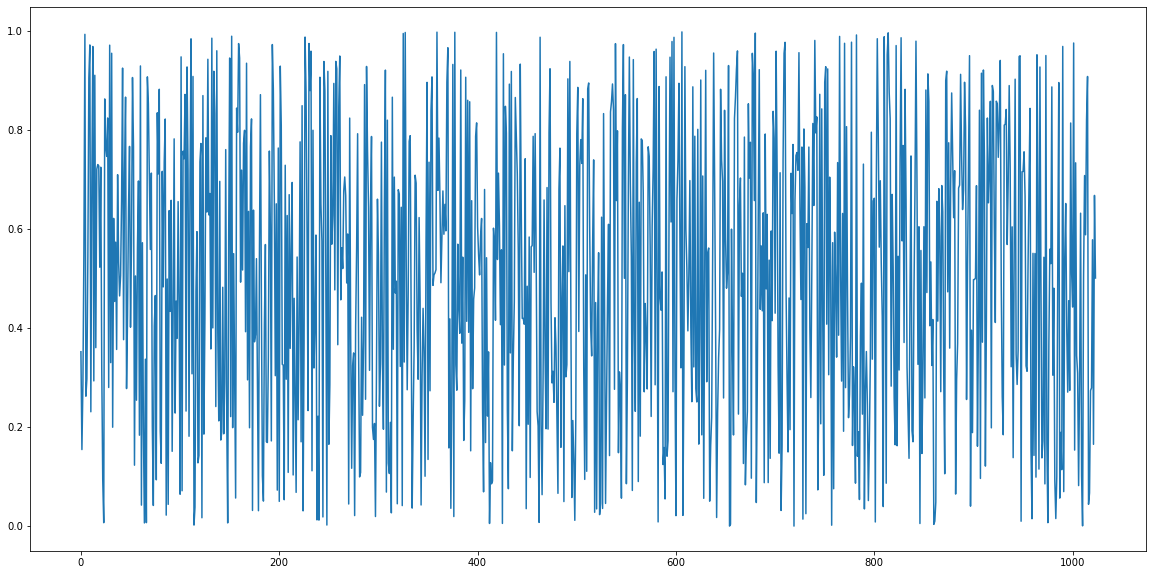

In [151]:
samples = np.random.rand(N//2)
plt.figure(figsize=(20,10))
plt.plot(samples)

5361
5361.0


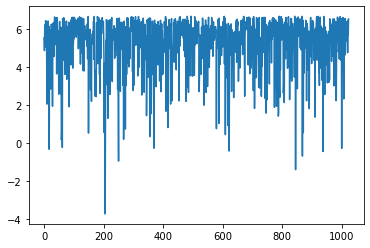

In [157]:
print(P)
print(np.sum(bit_allocation_xk(P, samples)))
plt.plot(bit_allocation_xk(P, np.random.rand(N//2)))

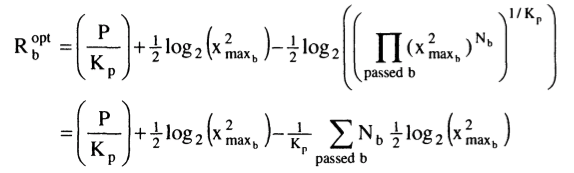

In [17]:
def bit_allocation(K_p, P, N_b, xmax_b):
# K_p: receiving bit subbands
# P: total quantity of bits, without scale
# N_b: spectral samples in sub-band b
#     print(list(np.multiply(N_b, np.log2(xmax_b ** 2))))
    avg = np.sum(0.5 * np.array(N_b) * np.log2(xmax_b ** 2))/K_p
#     print("avg = ", avg)
#     print("middle term = ", 0.5 * np.log2(xmax_b ** 2))
#     print("first term = ", P/K_p)
    return (P/K_p) + 0.5 * np.array(N_b) * np.log2(xmax_b ** 2) - avg

In [18]:
int(block_bits_per_channel(R_k(256000, fs), N) - 100)

5361

In [19]:
total_bits = int(block_bits_per_channel(R_k(256000, fs), N) - 100)
samples = np.random.rand(K)
allocation = bit_allocation(K, total_bits, list(k_map.values()), samples) 
allocation

array([248.95228977, 251.42244763, 250.85804   , 248.9472995 ,
       248.82733153, 250.79606058, 242.30207974, 244.39989626,
       249.89733774, 238.13204274, 237.31452671, 245.91451979,
       197.85502088, 242.23844739, 228.23248275, 186.1255876 ,
       250.45688221, 228.23647542, 183.16765326, 135.73058258,
       229.68087957,  92.42388433, 107.74883696, 172.575756  ,
       148.76363906])

In [20]:
np.sum(allocation)

5361.0

In [21]:
bit_allocation(K, total_bits, list(k_map.values()), np.ones(K))

array([214.44, 214.44, 214.44, 214.44, 214.44, 214.44, 214.44, 214.44,
       214.44, 214.44, 214.44, 214.44, 214.44, 214.44, 214.44, 214.44,
       214.44, 214.44, 214.44, 214.44, 214.44, 214.44, 214.44, 214.44,
       214.44])

In [22]:
class MDCT():
    def __init__(self, N: int, window: np.ndarray):
        K = N//2
        self.n_0 = ((N/2) + 1)/2

        A = np.zeros((K,N))
        for k in range(K):
            for n in range(N):
                A[k,n] = np.cos((2*np.pi/N)*(n + self.n_0)*(k+1/2))

        self.N = N
        self.window = window
        self.A_1 = A[:,:N//2]
        self.A_2 = A[:,N//2:]
        self.B_1 = (4/N)*self.A_1.T
        self.B_2 = (4/N)*self.A_2.T

        self.A = A
        self.B = (4/N)*A.T

        if window.shape[0] != N:
            raise ValueError(f"Window is not the same size as N! Window size: {window.shape[0]}")

    def _preprocess(self, x: np.ndarray):
        L = len(x)
        self.frames = L//(self.N//2) + 1
        r = L%(self.N//2)
        return np.pad(x, (self.N // 2, self.N // 2 - r))


    def mdct(self, x: np.ndarray):
        x_padded = self._preprocess(x)

        X = np.ndarray((self.A.shape[0], self.frames))
        for frame_idx in range(self.frames):
            frame = x_padded[frame_idx*(self.N//2):frame_idx*(self.N//2)+self.N]
            X[:, frame_idx] = self.A @ (frame * self.window)

        return X

    def imdct(self, X: np.ndarray):
        x_padded = np.zeros(self.frames * self.N//2 + self.N//2)
        for frame_idx in range(self.frames):
            x_padded[frame_idx*self.N//2:frame_idx*self.N//2 + self.N] += (self.B @ X[:,frame_idx]) * self.window
            
        return x_padded[self.N//2:-self.N//2]
    
    def mdct_pre_twiddle(self):
        return np.exp(-2j * np.pi * np.arange(self.N) / (2*self.N))

    def mdct_post_twiddle(self):
        return np.exp(-2j * np.pi * self.n_0 * (np.arange(self.N//2) + 0.5) / self.N)


    def mdct_via_fft(self, x):
        x_padded = self._preprocess(x)

        X = np.ndarray((self.A.shape[0], self.frames))
        for frame_idx in range(self.frames):
            frame = x_padded[frame_idx*(self.N//2):frame_idx*(self.N//2)+self.N]
            X[:, frame_idx] = np.real(
                self.mdct_post_twiddle() * np.fft.fft(frame * self.window * self.mdct_pre_twiddle())[:self.N//2]
            )
        
        return X 
    
    def imdct_pre_twiddle(self):
        return np.exp(2j * np.pi * self.n_0 * np.arange(self.N) / self.N)

    def imdct_post_twiddle(self):
        return np.exp(2j * np.pi * (np.arange(self.N) + self.n_0) / (2*self.N))
    
    def imdct_via_ifft(self, X):
        x_padded = np.zeros(self.frames * self.N//2 + self.N//2)
        for frame_idx in range(self.frames):
            x_padded[frame_idx*self.N//2:frame_idx*self.N//2 + self.N] += \
            np.real(np.fft.ifft(np.concatenate((X[:,frame_idx], -X[::-1,frame_idx])) * self.imdct_pre_twiddle()) * \
            self.imdct_post_twiddle()) * 2 * self.window
            
        return x_padded[self.N//2:-self.N//2]
        
def sine_window(N):
    M = N//2
    w = np.zeros((N,1))

    for n in range(N-M):
        w[n] = np.sin((np.pi/2)*(n+1/2)/(N-M))
        
    for n in range(N-M,M):
        w[n] = 1

    for n in range(M,N):
        w[n] = np.sin((np.pi/2)*(N - n - 1/2)/(N-M))

    return w.reshape(-1)

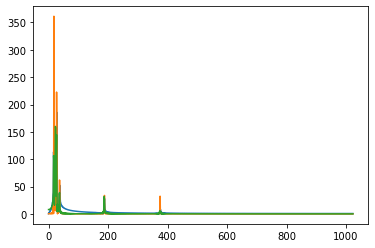

In [23]:
n = np.arange(N)
T = N/fs
t = np.linspace(0, T, N)

A0 = 0.6
A1 = 0.55
A2 = 0.55
A3 = 0.15
A4 = 0.1
A5 = 0.05


x = A0 * np.cos(2 * np.pi * n * 440/fs)  \
  + A1 * np.cos(2 * np.pi * n * 554/fs)  \
  + A2 * np.cos(2 * np.pi * n * 660/fs)  \
  + A3 * np.cos(2 * np.pi * n * 880/fs)  \
  + A4 * np.cos(2 * np.pi * n * 4400/fs) \
  + A5 * np.cos(2 * np.pi * n * 8800/fs)

my_mdct = MDCT(N, sine_window(N))

X = my_mdct.mdct(x)
plt.plot(np.abs(X))

# bit_allocation(K, total_bits, list(k_map.values()), np.abs(X) 

In [28]:
df = pd.DataFrame({'bin': range(1024), 'mdct': X[:, 1]})
df["subband"] = df["bin"].apply(bin_to_subband_index)
df.drop(columns = ["bin"], inplace = True)
x_max_b = df.groupby(by=["subband"]).max()["mdct"].to_numpy()
list(x_max_b)

[0.4966768818833763,
 0.7429672999517176,
 1.4116945568944923,
 4.456689101729564,
 76.5214720684173,
 132.0699253394949,
 27.645872037712028,
 28.555405519153695,
 1.3663761834522714,
 0.27027510731718857,
 0.18679256650612042,
 0.09195786851856913,
 0.06572046508932379,
 0.04418524341496713,
 0.02961584693489365,
 0.022214364606173508,
 0.02765263428660914,
 20.666898274915134,
 0.10499554135524414,
 0.009644693284610904,
 0.005523728201431158,
 32.381066786587645,
 0.026285635391937325,
 0.0015148725712744735,
 0.0005077970079336858]

In [34]:
alloc = bit_allocation(K, total_bits, list(k_map.values()), x_max_b)
alloc

array([  482.13334897,   485.46693394,   489.66859132,   495.80534075,
         518.47041507,   522.4072423 ,   515.91540451,   516.19560327,
         490.3339346 ,   473.96895531,   465.397032  ,   452.75261983,
         443.97880296,   419.67707809,   400.86417508,   366.34945858,
         352.59403053,   622.62820077,   370.12385039,   199.25134767,
          97.17406996,   818.30863976,   -16.77838029, -1114.50506971,
       -3507.18162566])

In [35]:
np.sum(alloc)

5360.999999999998